# <span style="color:red"> Numerical Simulation Laboratory (NSL) </span>

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import math

<h1><font color='ForestGreen'>ESERCITAZIONE 7: METROPOLIS, ENSAMBLE CANONICO SISTEMA NELLO STATO SOLIDO, LIQUIDO, GASSOSO</font> </h1>

<h3><font color = 'LightGreen'>Intro:</font></h3>

In questa esercitazione l'obiettivo e' sviluppare una analisi termodinamica nell'insieme statistico dell'ensamble canonico per una sostanza nello stato solido, liquido e gassoso, i cui parametri sono i medesimi dell'esercitazione 4 sulla dinamica molecolare.

In termini generali, questo ensemble rappresenta una situazione sperimentale in cui il valore della temperatura 
è fissata, il che e' analogo a dire che il sistema si trova in contatto con un bagno termico: motivo per cui tale ensable e' identificato dalla tripletta di variabili termodinamiche NVT, a indicare che numero di particelle, volume e temperatura costanti.
Da un punto di vista proabilistico, viceversa, si ha che l'ensemble canonico è invece definito dal peso di boltzmann associato a ciascun microstato:
$P_i= \frac{e^{-\beta E_i}}{Z}$
dove $Z = \sum_{i}e^{-\beta H}$ e' la funzione di partizione.

<h3><font color = 'LightGreen'>Implementazione:</font></h3>

Per svolgere questa simulazione si e' sfruttato l'algoritmo di metropolis al fine di campionare la distribuzione di probabilita' propria dell'ensamble canonico. Per farlo, si e' optato di adottare un passo di transizione uniforme, la cui ampiezza delta e' stata trovata in modo tale da essere $\frac{N_{acc}}{N_{Tent}} \sim 0.5$. Come sempre, si ha:
<p style = "text-align:center"> $A(\nu|\mu)=min \left [1, \frac{p(\nu)}{p(\mu)} \right ]=min \left [1, {e^{-\beta \Delta E}} \right ]$ </p>
I dati del problema, sono i medesime dell'esercitazione 4:<br>

1. solid phase: $\rho^\star = 1.1$,  $T^{\star}_{target} = 0.8$,  (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^{\star}_{target} = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$,  $T^{\star}_{target} = 1.2$ (cut-off radius: $r_c = 5.0$)

In questo eleborato, inoltre, si sono introdotte pure le correzioni di coda:
<p style = "text-align:center">$ U_{tail}=8 N_{part} \pi \rho (\frac{r_{cut}^{-9}}{9}-\frac{r_{cut}^{-3}}{3})$</p>
<p style = "text-align:center">$P_{tail}=32 \frac{N_{part}}{V} \pi \rho (\frac{r_{cut}^{-9}}{9}-\frac{r_{cut}^{-3}}{6})$</p>

Una importante osservazione e' che se nella lezione 4 si è reso necessario effettuare una modifica alla temperatura di input affinchè la temperatura target corrispondesse a quella desiderata, in questo caso non è necessario poichè il sistema è di tipo NVT e pertanto conserva la temperatura. Per altri tipi di ensamble statistici, in cui T non e' fissata, questa procedura puo' tornare ad essere necessaria.

<h3><font color = 'LightGreen'>Equilibrazione:</font></h3>

Fissato il numero di particelle all'interno del box in PBC uguale a $npart = 108$, si equilibra il sistema per un numero di blocchi
a singolo step pari a $N = 2000$.<br>
Inizializziamo quindi le variabili di interesse.

In [54]:
npart = 108 #NUMERO PARTICELLE

N = 2000 #NUMERO BLOCCHI A SINGOLO ELEMENTO PER EQUILIBRAZIONE
x = np.arange(N)+1    # SI FA USO DELL'ORDINAMENTO DA 1 A N

phase = ["GAS", "LIQUID", "SOLID"]
phase_z = ["zoom_GAS", "zoom_LIQUID", "zoom_SOLID"]
colors = ["DarkMagenta","DarkSlateBlue","FireBrick"]
k=0

Per l'equilibrazione si inizia pure in questom caso dalla configurazione cristallina fcc, ove, per come gia' osservato, la T di partenza corrisponde alla T target in quanto nell'ensamble canonico tale quantita' e' fissata.

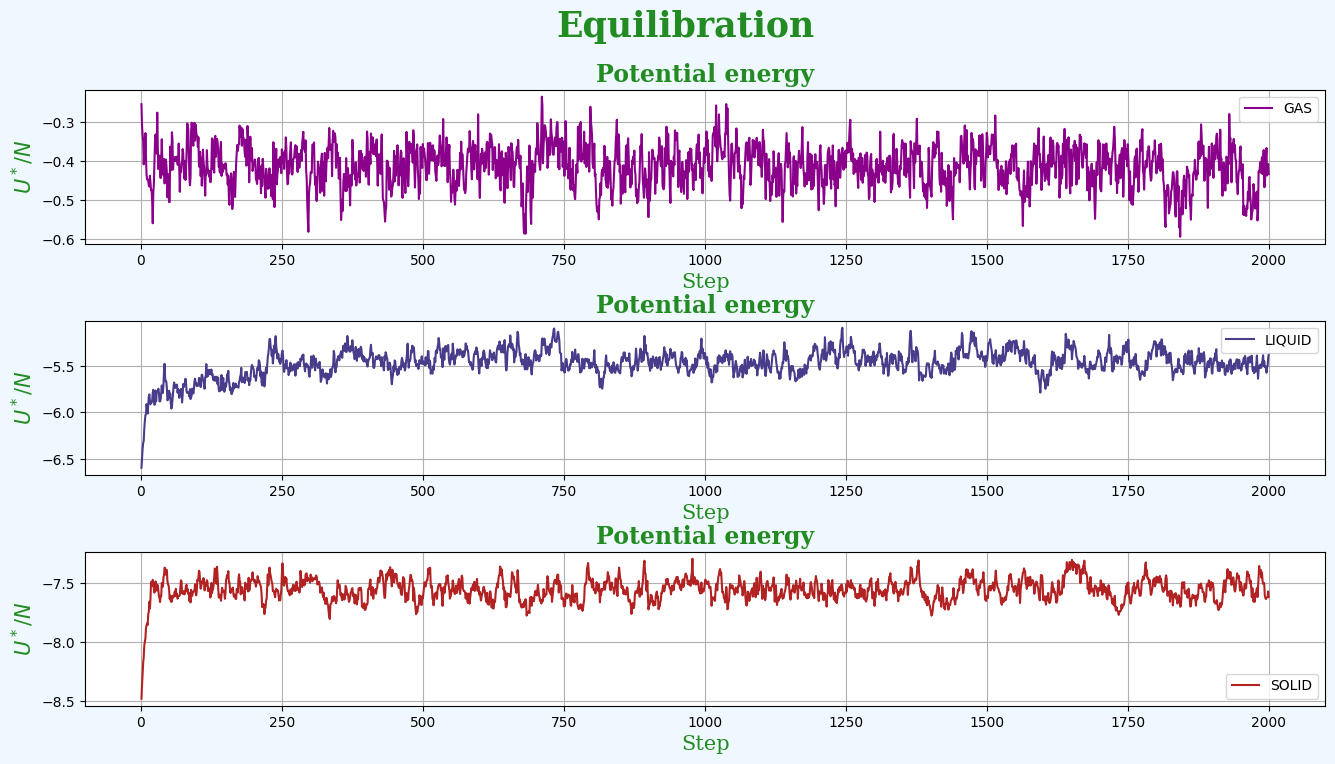

In [56]:

plt.figure(figsize=(16,8), facecolor = "AliceBlue")
plt.suptitle("Equilibration", fontsize = 25, fontweight = "bold", color = "ForestGreen", family = "Serif")

for i in range(0,3):
    plt.subplot(3,1,i+1)
    U = np.loadtxt("EX_7.1/OUTPUT_FILE/MC/"+phase[i]+"_FILE/EQUILIBRAZIONE/output_epot.dat", usecols=(1), delimiter=' ', unpack='true')
    plt.plot(x, U, marker='', label=phase[i], color = colors[i])
    plt.title('Potential energy', fontsize = 17, fontweight = "bold", color = "ForestGreen", family = "Serif")
    font = {"family":"serif", "color":"ForestGreen", "size":"15"}
    plt.ylabel('$U^*/N$', fontdict = font)
    plt.xlabel('Step', fontdict = font)
    plt.grid(True)
    plt.legend()
    plt.subplots_adjust(hspace=0.5)

plt.show()

Fatto cio', abbiamo una configurazione da cui far ripartire il sistema ed andare ad effettuare la simulazione,

<h2><font color = 'LimeGreen'>ESERCIZIO 7.2: Teorema del viriale, calcolo pressione</font></h2>

<h3><font color = 'LightGreen'>Autocorrelazione:</font></h3>

Prima di procedere con la simulazione, in qualsivoglia simulazione MC con metropolis e' opportuno se non necessario andare
a studiare la funzione di autocorrelazione.

Per definizione stessa di catena di markov, e' evidente che nelle simulazioni basate sull'algoritmo di Metropolis se eseguiamo due misurazioni dell'energia interna separate da un singolo step Monte Carlo, i valori verranno molto simili e sara' presente una importante correlazione tra le misure. Per avere campionamenti statisticamente indipendenti dobbiamo, invece, estrarre valori dell'energia interna ad intervalli maggiori di circa due volte il tempo di correlazione, dove e' il tempo a cui la funzione che descrive l'autocorrelazione e' diminuita di un fattore 1/e.

Ragion per cui, per realizzare il data blocking in maniera efficiente ed estrapolare misurazioni indipendenti, dobbiamo stimare 
 in unita' di step del Monte Carlo e porre il numero di step in ogni blocco molto maggiore del tempo di correlazione di Utilizziamo, quindi, il dataset precedentemente acquisito di 
 misurazioni istantanee di 
 per andare ad analizzare la funzione di autocorrelazione:
<p style = "text-align:center">
$\chi(t) = \frac
    {
        \frac{1}{t_{max}-t}
            \sum_0^{t_{max}-t} m(t')m(t'+t)
        -\frac{1}{t_{max}-t}
            \sum_0^{t_{max}-t} m(t')
         \times
         \frac{1}{t_{max}-t}
            \sum_0^{t_{max}-t} m(t'+t)
    }
    {
        \frac{1}{t_{max}}
            \sum_0^{t_{max}} m^2(t')
        -\left(
            \frac{1}{t_{max}}
                \sum_0^{t_{max}} m(t')
        \right)^2
    }
    $
</p>

Riportati per chiarezza ancora i dati di input:

In [59]:
npart = 108

N = 30000
x = np.arange(N)+1    # uso l'ordinamento da 1 a N

phase = ["GAS", "LIQUID", "SOLID"]
phase_z = ["gas-zoom", "liquid-zoom", "solid-zoom"]
colors = ["DarkMagenta","DarkSlateBlue","FireBrick"]

U_g = U_l = U_s = []
U = [U_g, U_l, U_s]

Se eseguiamo l'equilibrazione con $N = 30000$, troviamo:

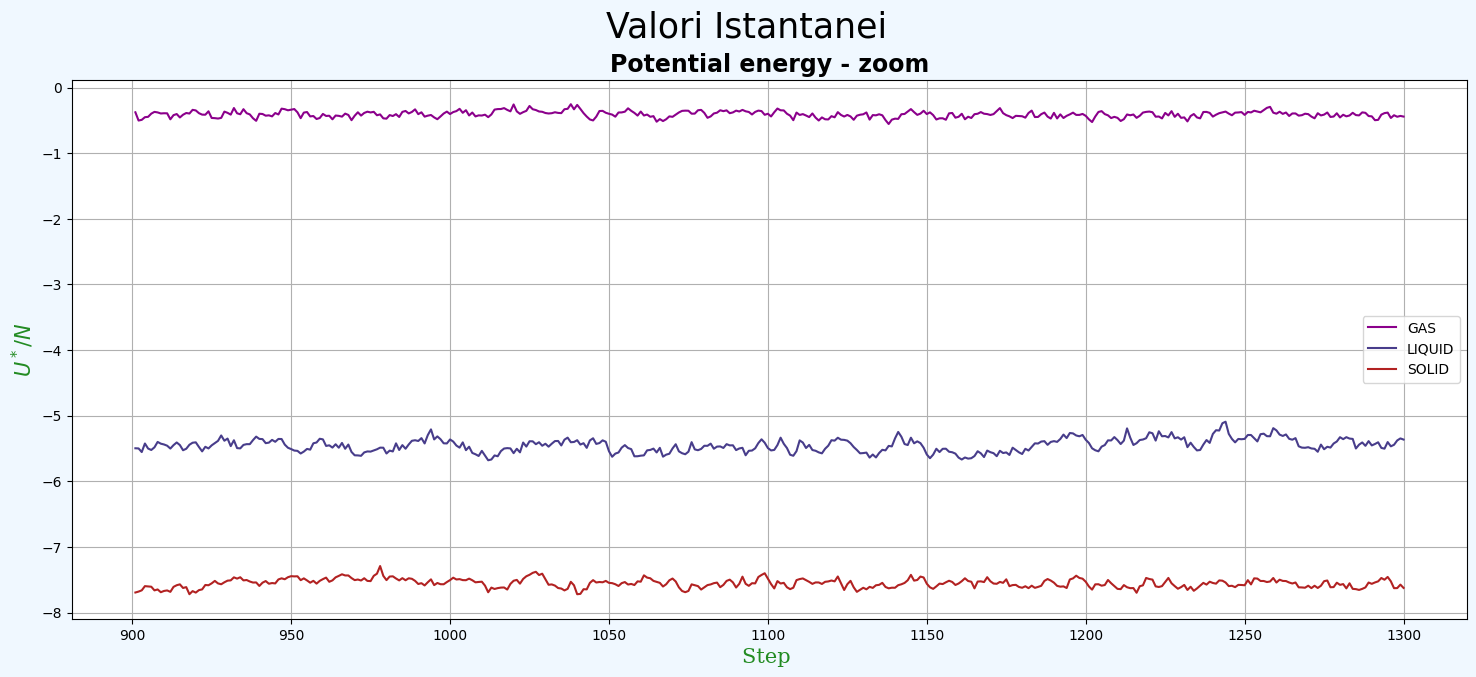

In [62]:
U_g = U_l = U_s = []
U = [U_g, U_l, U_s]

plt.figure(figsize=(18,7), facecolor = "AliceBlue")
plt.suptitle("Valori Istantanei", fontsize = 25)



 


for i in range(0,3):
    U[i] = np.loadtxt("EX_7.1/OUTPUT_FILE/MC/"+phase[i]+"_FILE/EQUILIBRAZIONE_CORRELAZIONE/output_epot.dat", usecols=(1), delimiter=' ', unpack='true')
    plt.plot(x[900:1300], U[i][900:1300], marker='', label=phase[i], color = colors[i])
    plt.title('Potential energy - zoom', fontsize = 17, fontweight = "bold")
    font = {"family":"serif", "color":"ForestGreen", "size":"15"}
    plt.ylabel('$U^*/N$', fontdict = font)
    plt.xlabel('Step ', fontdict = font)
    plt.grid(True)
    plt.legend()
    
plt.show()

In [71]:

tmax = N
taumax = 200
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")
print("tMAX =", tmax)
print("tauMAX =", taumax)

print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

tMAX = 30000
tauMAX = 200

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




tau DI 200 PER LA FASE GAS: 
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
tau DI 200 PER LA FASE LIQUID: 
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 
tau DI 200 PER LA FASE SOLID: 
0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 

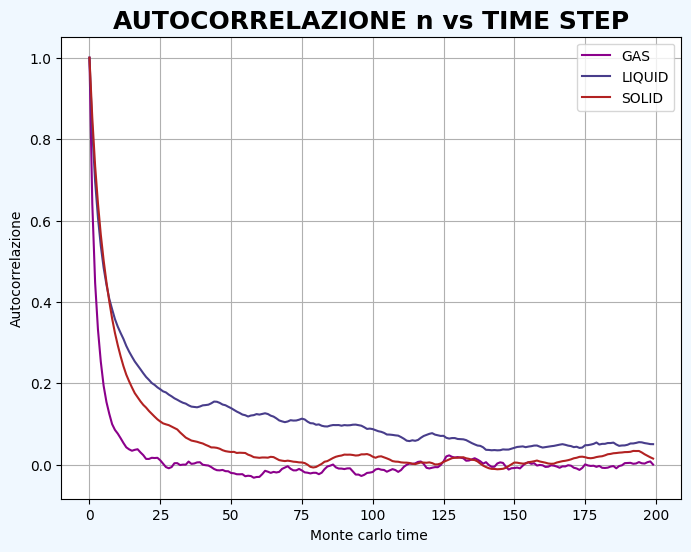

In [68]:
plt.figure(figsize=(8,6), facecolor = "AliceBlue")

for i in range(0,3):#CICLO SU CURVE

    susc = []

    print("\ntau DI "+str(taumax)+" PER LA FASE "+phase[i]+": ")
    for tau in range(taumax):#SVILUPPIAMO FINO A 
        su1=0
        su2=0
        su3=0
        su4=0
        su5=0
        for T in range(tmax):
            su4 += U[i][T]*U[i][T]
            su5 += U[i][T]
            
        for T in range(tmax-tau):
            su3 += U[i][T+tau]
            su2 += U[i][T]
            su1 += U[i][T]*U[i][T+tau]

        

        f = 1/(tmax-tau)
        f2 = 1/tmax

        num = f*su1-f*su2*f*su3
        den = f2*su4 - (f2*su5)*(f2*su5)

        susc.append(num/den)

        if tau%10==0:
            print(tau, end= ", ")

    plt.plot(susc, color = colors[i], label = phase[i])
    plt.xlabel("Monte carlo time ")
    plt.ylabel("Autocorrelazione")
    plt.legend()
    plt.grid()

plt.title("AUTOCORRELAZIONE n vs TIME STEP", fontsize = 18, fontweight = "bold")
plt.show()


Come emerge chiaramente, dopo circa 20 tempi MC si puo' affermare che la funzione di correlazione si e' abbassata signifcativamente.
Questo ha una conseguenza importante: laddove si prendessero come numero di passi per blocco un numero minore di quello per cui c'e' autocorrelazione, 
i blocchi sarebbero tutti fortemente correlati e sottostimeremmo sistematicamente l'incertezza statistica sulle medie progressive del metodo a blocchi.


In [43]:
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ #


def dataBlocking(x, N, L):
    mean=0
    mean2=0
    error=0
    for n in range(N):
        mean_block=0
        for l in range(L):
            mean_block+=x[l+n*L]
        mean_block/=L
        mean=(mean*n+mean_block)/(n+1)
        mean2=(mean2*n+mean_block**2)/(n+1)
        error=Error(mean, mean2,n)
    return error
def Error(ave, ave2, n):
    if(n==0): 
        return 0
    return np.sqrt((ave2-ave**2)/n)    
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$#

In [70]:
L_m=10
L_M=5000
M=30000
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")
print("NUMERO THROWS =", M)
print("NUMERO ELEMENTI PER BLOCCO MINIMO =", L_m)
print("NUMERO ELEMENTI PER BLOCCO MASSIMO =",L_M)
print("")
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("")


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

NUMERO THROWS = 30000
NUMERO ELEMENTI PER BLOCCO MINIMO = 10
NUMERO ELEMENTI PER BLOCCO MASSIMO = 5000

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




L DI 5000 PER IL GAS: 
500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 
L DI 5000 PER IL LIQUID: 
500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 
L DI 5000 PER IL SOLID: 
500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 

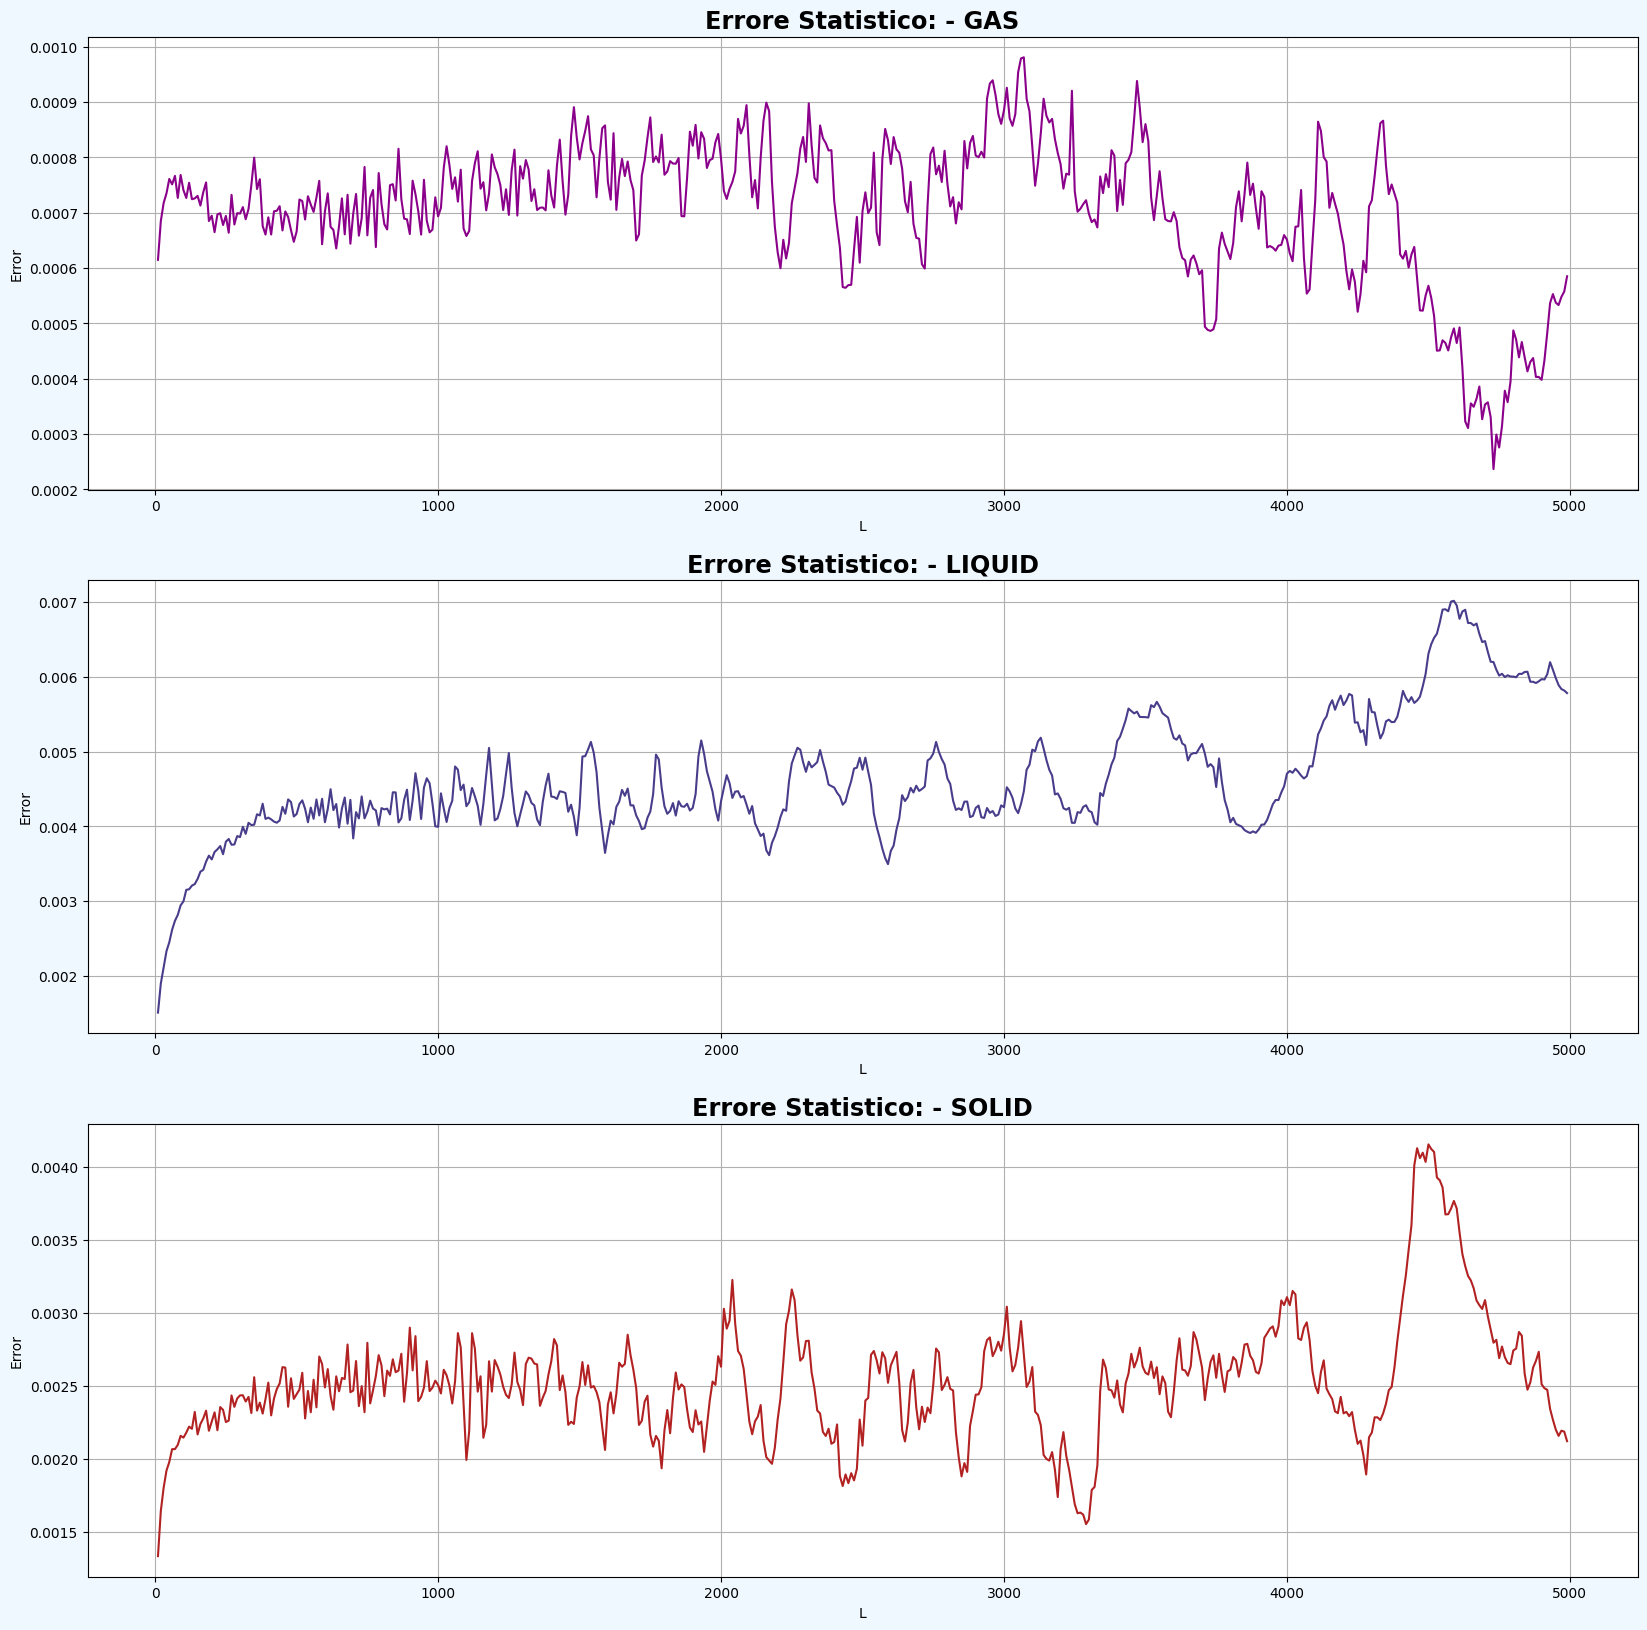

In [47]:
fig=plt.figure(figsize=(20, 20), facecolor = "AliceBlue")

for i in range(0,3):
    plt.subplot(3,1,i+1)
    plt.title("Errore Statistico: - "+phase[i], size='xx-large', weight='bold')

    y=U[i] # data loaded in 7.1
    error=[]
    x=[]

    L_range = range(10,5000, 10)

    print("\nL DI "+str(L_M)+" PER IL "+phase[i]+": ")
    for L in L_range: 
        if L%500==0:
            print(L, end = ", ")
        N=int(M/L)
        err=dataBlocking(y,N,L)
        error.append(err)
        x.append(L)

    plt.plot(x, error, label = phase[i], color = colors[i])
        
    plt.ylabel("Error")
    plt.xlabel('L')
    plt.grid(True)
        
plt.show()


Osserviamo come, andando ad un numero di step per blocco sufficientemente grande rispetto al tempo di correlazione trovato studiando la funzione di autocorrelazione, l'incertezza statistica segue una curva che satura ad un valore finito, oscillando attorno ad un valore costante: questo vuol dire che essa non e' piu' sottostimata e i blocchi non sono piu' tra loro correlati.
Possiamo, invece, notare come se siamo ad un numero di step basso rispetto al tempo di correlazione, l'incertezza statistica e' sottostimata e i blocchi sono tra loro correlati.

In base a questa analisi basata sul calcolo della funzione di autocorrelazione e sullo studio dell'andamento dell'incertezza statistica in funzione della lunghezza dei blocchi, possiamo affermare che per implementare in maniera efficiente e sapiente il data blocking dovremo avere almeno 2000 step per blocco.

<h3><font color = 'LightGreen'>Distribuzione Radiale:</font></h3>

La distribuzione radiale e' una quantita' strutturale particolarmente importante che indica la proabilita' di trovare una coppia di atomi a distanza r tra loro: da un punto di vista microscopico, se vogliamo, va a rappresentare come varia la densita' di materia in funzione della distanza da una origine di riferimento. Il motivo per cui risulta utile andarsi a determinare tale quantita' e' che permette di ricavarsi poi valori di aspttazioni di ossservabili many body come il potenziale di interazione.
Piu' esplicitamente, la relazione che lo definisce e' la seguente:$g(r) =\frac{1}{\rho N\Delta V(r)} 
    \left\langle \sum_{i=1}^N \sum_{j=1,\neq i}^N \delta(r-|\vec r_i-\vec r_j |) \right\rangle$.

Nella pratica, per implementarlo occorre dividere l'intervallo 
in tot sotto-intervalli, bin, per poi ciclare su tutte le coppie non ripetute di particelle acon increment +2: cosi' facendo si contano entramble le particelle.

[50 blocchi, 2000 step)]


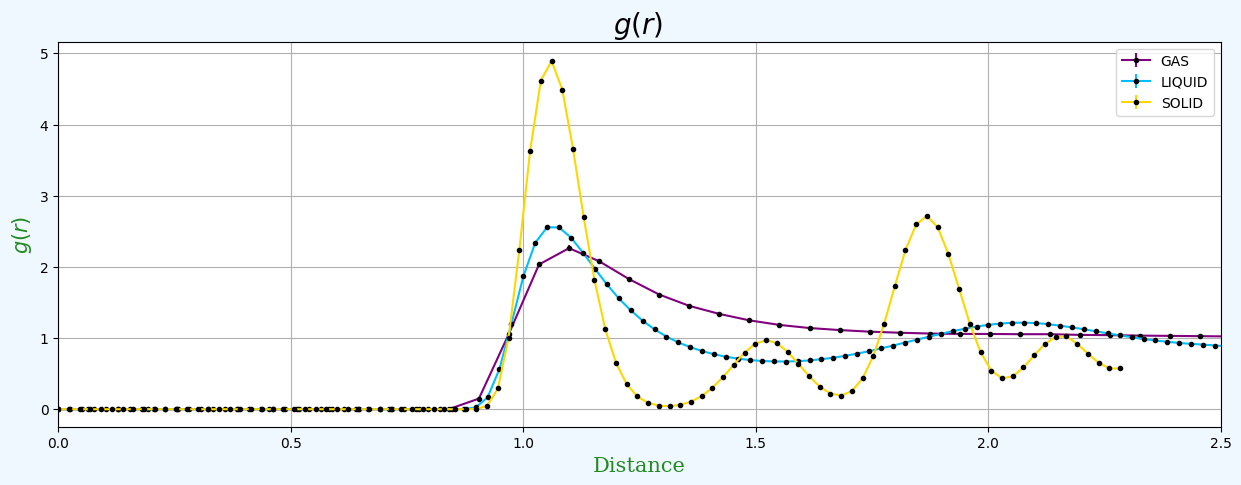

In [48]:

colors = ["Purple","DeepSkyBlue","Gold"]
phase = ["GAS", "LIQUID", "SOLID"]

ng = 100
x=np.arange(0,ng)

# box scaling
rho = [0.05, 0.8, 1.1]
npart = 108
L = [0.0,0.0,0.0]
for i in range(3):
    L[i] = ((rho[i]/npart)**(-1/3))/200

fig=plt.figure(figsize=(15, 5), facecolor = "AliceBlue")

for i in range(0,3):

    gdr = np.loadtxt("EX_7.1/OUTPUT_FILE/MC/"+phase[i]+"_FILE/output_gdr.dat", usecols=range(0,100), unpack='true', max_rows=ng)
    y = np.mean(gdr, axis=1)
    err = np.std(gdr, axis=1)
    plt.errorbar(x*L[i], y, err, marker='.', mec ="black", mfc = "black", label=phase[i], color = colors[i])
    plt.title('$g(r)$ ', size='20', weight='bold')
    font = {"family":"serif", "color":"ForestGreen", "size":"15"}
    plt.ylabel('$g(r)$', fontdict = font)
    plt.xlabel('Distance', fontdict =font)
    plt.grid(True)
    plt.legend()
    plt.xlim(0,2.5)

print("[50 blocchi, 2000 step)]")


plt.show()

<h3><font color = 'LightGreen'>Simulazione: Fase Solida, Liquida e Gassosa</font></h3>

In [75]:
algorithm = ["MC", "MD"]
colors = [["r", [1,0.7,0.6]],["g",[0.7,1,0.6]],["b",[0.7,0.6,1]]]
phase = ["GAS", "LIQUID", "SOLID"]
npart = 108



# box scaling
rho = [0.05, 0.8, 1.1]
L = [0.0,0.0,0.0]
for i in range(3):
    L[i] = ((rho[i]/npart)**(-1/3))/200
therm = ["epot",             "pres",     "gdr",                 "gdr_diff"               ]
titles       = ["ENERGIA POT.", "PRESSIONE", "DIST. RADIALE g(r)",    "$g(r)_{MC}-g(r)_{MD}$"  ] 
uts        = ["U*/N",             "p*",       "g(r)",                "g(r)"                   ]
ax        = ["BLOCCHI",          "BLOCCHI",  "DISTANZA NORMALIZZATA", "DISTANZA NORMALIZZATA"    ]

In [ ]:
<h3><font color = 'LightGreen'>Simulazione: Fase Solida, Liquida e Gassosa</font></h3>

<h4><font color = 'Black'>Fase Solida</font></h4>

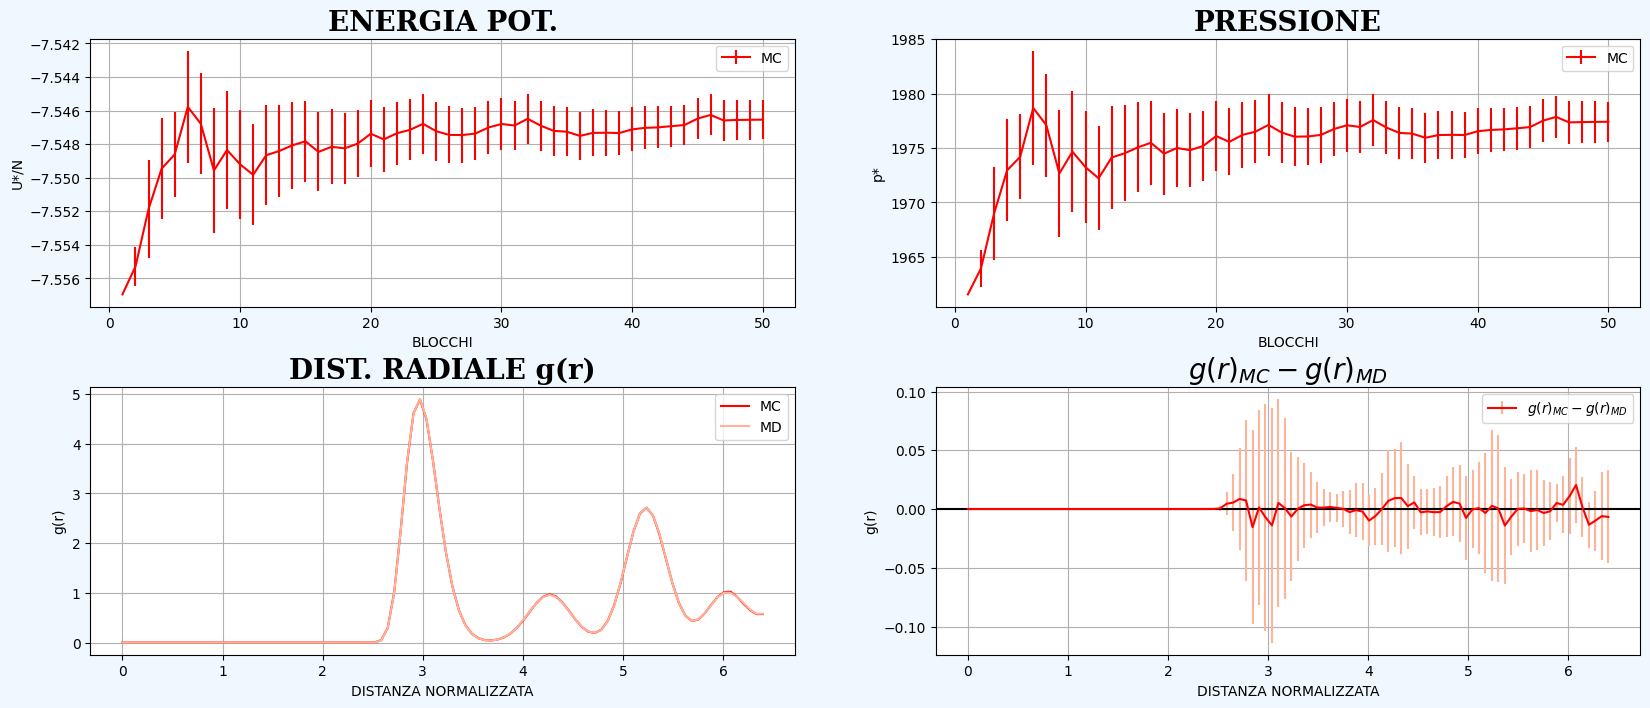

In [76]:
fig=plt.figure(figsize=(20, 8), facecolor = "AliceBlue")
pl_index = 0
a = 0 # phase index
b = 0 # th_var index
c = 0 # alg index

ng = 100
x=np.arange(0,ng)

phase = "SOLID"
for s in therm:

    pl_index +=1
    plt.subplot(2,2,pl_index)

    if s == "pres" or s == "epot":
        x, y , err= np.loadtxt("EX_7.1/OUTPUT_FILE/MC/"+phase+"_FILE/output_"+s+".dat", usecols = (0, 2, 3), delimiter = " ", unpack='true')
     
        plt.errorbar(x, y, err, marker='', label="MC", color = colors[a][0])


    if s== "gdr":
        # ciclo su MC/MD
        for alg in algorithm:
            gdr = np.loadtxt("EX_7.1/OUTPUT_FILE/"+alg+"/"+phase+"_FILE/output_gdr.dat", usecols=range(0,100), unpack='true', max_rows=ng)
            y = np.mean(gdr, axis=1)
            x=np.arange(0,100)
            plt.plot(x*L[a], y, marker='', label=alg, color = colors[a][c])
            c+=1

    if s == "gdr_diff":
        # ciclo su MC/MD
        gdrMC = np.loadtxt("EX_7.1/OUTPUT_FILE/MC/"+phase+"_FILE/output_gdr.dat", usecols=range(0,100), unpack='true', max_rows=ng)
        gdrMD = np.loadtxt("EX_7.1/OUTPUT_FILE/MD/"+phase+"_FILE/output_gdr.dat", usecols=range(0,100), unpack='true', max_rows=ng)
        y = np.mean(gdrMC, axis=1)-np.mean(gdrMD, axis=1)
        err = np.std(gdrMC, axis=1)+np.std(gdrMD, axis=1)
        x=np.arange(0,100)
        plt.errorbar(x*L[a], y, err, marker='', label="$g(r)_{MC}-g(r)_{MD}$", color = colors[a][0], ecolor = colors[a][1])
        
        plt.axhline(y=0, color = "k")

    plt.title(titles[b], size='20', weight='bold', family = "serif")
    plt.ylabel(uts[b])
    plt.xlabel(ax[b])
    plt.grid(True)
    plt.legend()
    c=0
    b+=1



plt.subplots_adjust(hspace=0.3)

plt.show()

<h4><font color = 'Black'>Fase Liquida</font></h4>

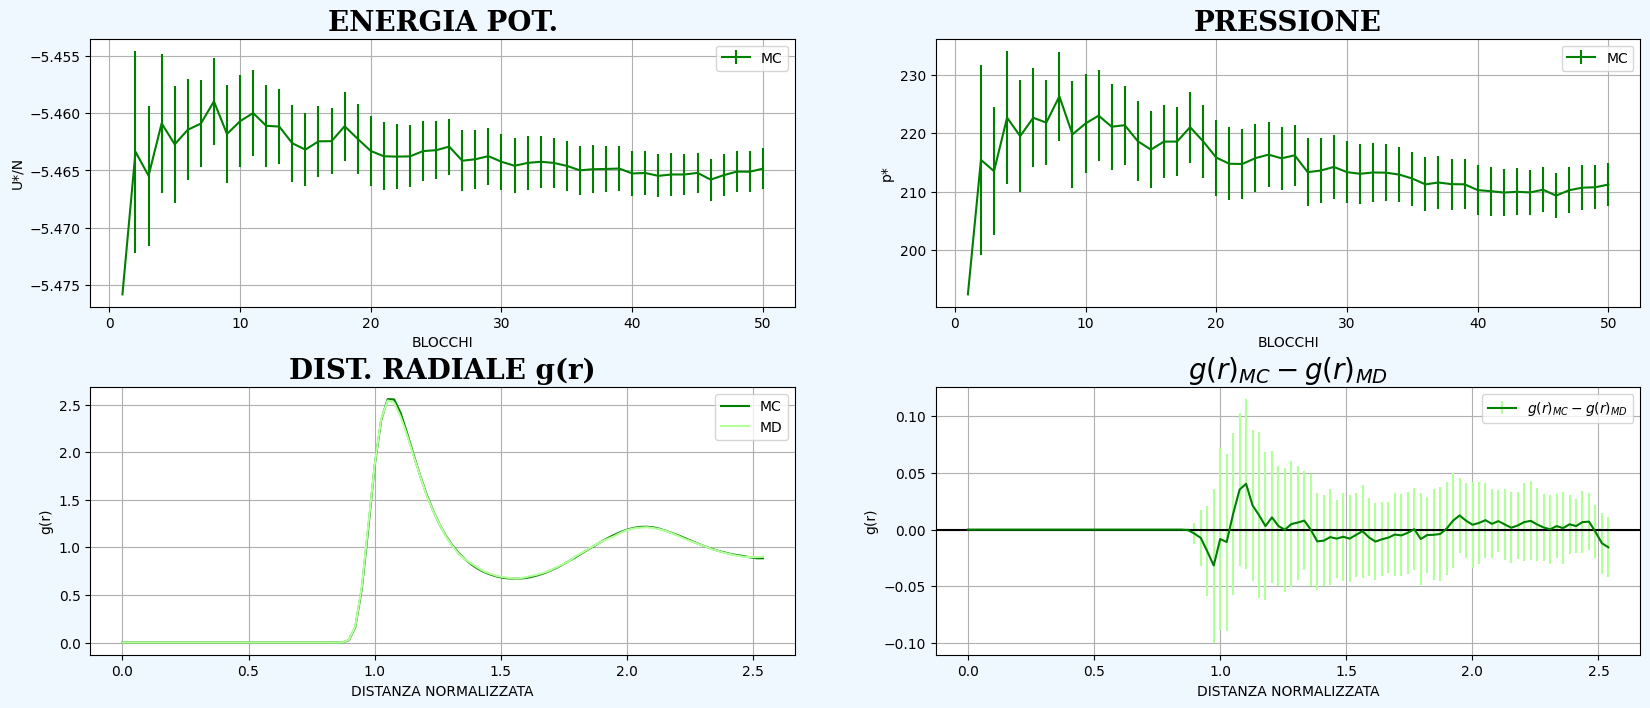

In [77]:
fig=plt.figure(figsize=(20, 8), facecolor = "AliceBlue")
pl_index = 0
a = 1 # phase index
b = 0 # th_var index
c = 0 # alg index

ng = 100
x=np.arange(0,ng)

phase = "LIQUID"
for s in therm:

    pl_index +=1
    plt.subplot(2,2,pl_index)

    if s == "pres" or s == "epot":
        x, y , err= np.loadtxt("EX_7.1/OUTPUT_FILE/MC/"+phase+"_FILE/output_"+s+".dat", usecols = (0, 2, 3), delimiter = " ", unpack='true')
     
        plt.errorbar(x, y, err, marker='', label="MC", color = colors[a][0])


    if s== "gdr":
        # ciclo su MC/MD
        for alg in algorithm:
            gdr = np.loadtxt("EX_7.1/OUTPUT_FILE/"+alg+"/"+phase+"_FILE/output_gdr.dat", usecols=range(0,100), unpack='true', max_rows=ng)
            y = np.mean(gdr, axis=1)
            x=np.arange(0,100)
            plt.plot(x*L[a], y, marker='', label=alg, color = colors[a][c])
            c+=1

    if s == "gdr_diff":
        # ciclo su MC/MD
        gdrMC = np.loadtxt("EX_7.1/OUTPUT_FILE/MC/"+phase+"_FILE/output_gdr.dat", usecols=range(0,100), unpack='true', max_rows=ng)
        gdrMD = np.loadtxt("EX_7.1/OUTPUT_FILE/MD/"+phase+"_FILE/output_gdr.dat", usecols=range(0,100), unpack='true', max_rows=ng)
        y = np.mean(gdrMC, axis=1)-np.mean(gdrMD, axis=1)
        err = np.std(gdrMC, axis=1)+np.std(gdrMD, axis=1)
        x=np.arange(0,100)
        plt.errorbar(x*L[a], y, err, marker='', label="$g(r)_{MC}-g(r)_{MD}$", color = colors[a][0], ecolor = colors[a][1])
        
        plt.axhline(y=0, color = "k")

    plt.title(titles[b], size='20', weight='bold', family = "serif")
    plt.ylabel(uts[b])
    plt.xlabel(ax[b])
    plt.grid(True)
    plt.legend()
    c=0
    b+=1



plt.subplots_adjust(hspace=0.3)

plt.show()

<h4><font color = 'Black'>Fase Gassosa</font></h4>

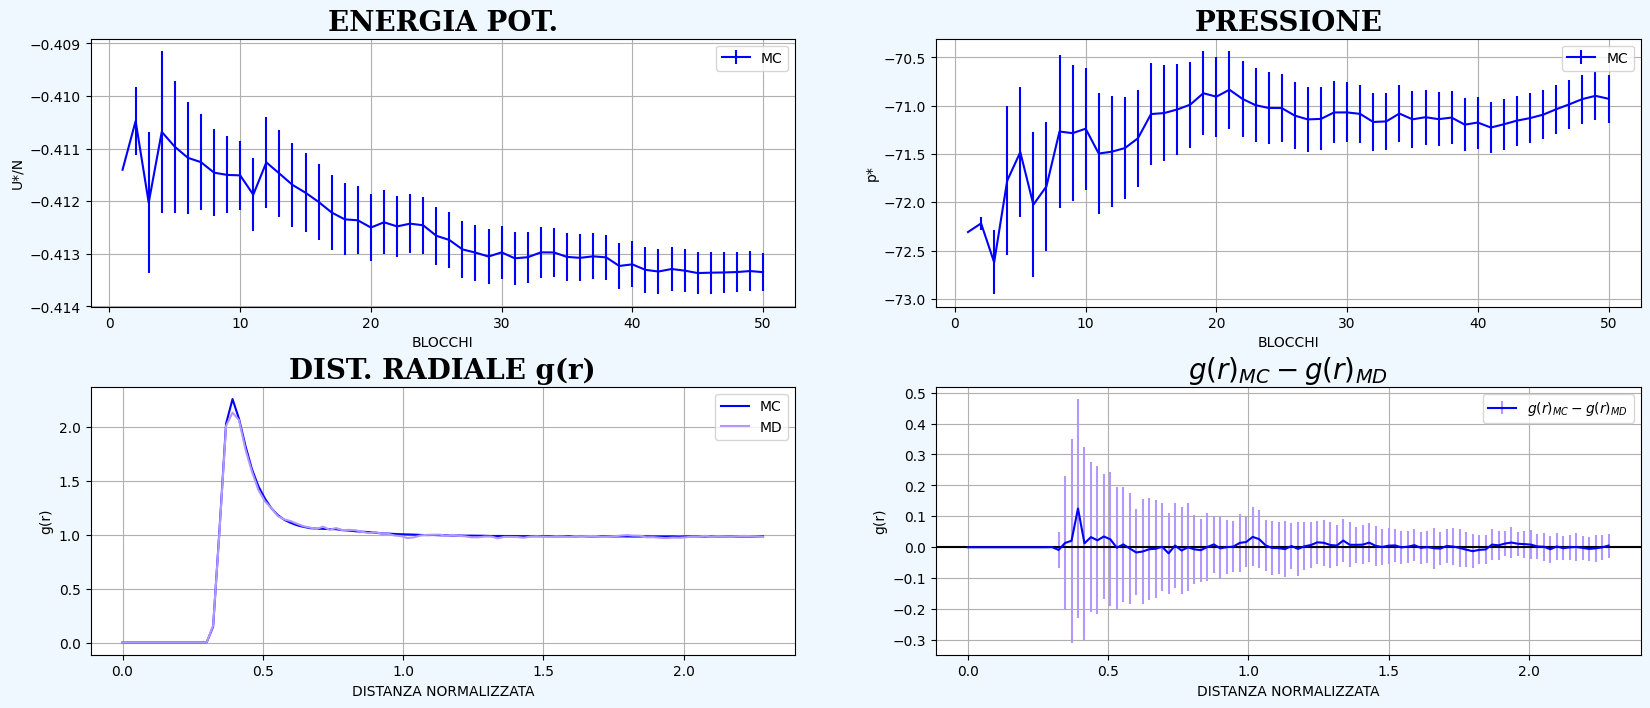

In [78]:
fig=plt.figure(figsize=(20, 8), facecolor = "AliceBlue")
pl_index = 0
a = 2 # phase index
b = 0 # th_var index
c = 0 # alg index

ng = 100
x=np.arange(0,ng)

phase = "GAS"
for s in therm:

    pl_index +=1
    plt.subplot(2,2,pl_index)

    if s == "pres" or s == "epot":
        x, y , err= np.loadtxt("EX_7.1/OUTPUT_FILE/MC/"+phase+"_FILE/output_"+s+".dat", usecols = (0, 2, 3), delimiter = " ", unpack='true')
     
        plt.errorbar(x, y, err, marker='', label="MC", color = colors[a][0])


    if s== "gdr":
        # ciclo su MC/MD
        for alg in algorithm:
            gdr = np.loadtxt("EX_7.1/OUTPUT_FILE/"+alg+"/"+phase+"_FILE/output_gdr.dat", usecols=range(0,100), unpack='true', max_rows=ng)
            y = np.mean(gdr, axis=1)
            x=np.arange(0,100)
            plt.plot(x*L[a], y, marker='', label=alg, color = colors[a][c])
            c+=1

    if s == "gdr_diff":
        # ciclo su MC/MD
        gdrMC = np.loadtxt("EX_7.1/OUTPUT_FILE/MC/"+phase+"_FILE/output_gdr.dat", usecols=range(0,100), unpack='true', max_rows=ng)
        gdrMD = np.loadtxt("EX_7.1/OUTPUT_FILE/MD/"+phase+"_FILE/output_gdr.dat", usecols=range(0,100), unpack='true', max_rows=ng)
        y = np.mean(gdrMC, axis=1)-np.mean(gdrMD, axis=1)
        err = np.std(gdrMC, axis=1)+np.std(gdrMD, axis=1)
        x=np.arange(0,100)
        plt.errorbar(x*L[a], y, err, marker='', label="$g(r)_{MC}-g(r)_{MD}$", color = colors[a][0], ecolor = colors[a][1])
        
        plt.axhline(y=0, color = "k")

    plt.title(titles[b], size='20', weight='bold', family = "serif")
    plt.ylabel(uts[b])
    plt.xlabel(ax[b])
    plt.grid(True)
    plt.legend()
    c=0
    b+=1



plt.subplots_adjust(hspace=0.3)

plt.show()